## Import libraries and setup
Load required libraries and modules for data handling, plotting, and NeuralHydrology utilities.

In [2]:


import sys
from pathlib import Path

sys.path.append("../..")

import matplotlib.pyplot as plt
import torch
from neuralhydrology.evaluation import metrics
from neuralhydrology.nh_run import start_run, eval_run, finetune
from neuralhydrology.utils.config import Config
from neuralhydrology.datasetzoo.hysets import load_hysets_timeseries, load_hysets_boundaries
import neuralhydrology.datasetzoo.hysets as hs 
from neuralhydrology.utils.config import Config
from neuralhydrology.datautils.clusterutils import cluster_basin_attributes
from neuralhydrology.utils.run_analysis import eval_all_runs


import pandas as pd

import pickle
import numpy as np

data_dir = Path(r"F:\Data\LSH\HYSETS_2023")

## Load configuration and preprocess basin data
Load configuration, basin boundaries, data availability, and attributes. Filter and cluster basins.

In [3]:

cfg = Config(Path("hysets_basins.yml"))

# Load basin boundaries and filter for HYDAT source
boundaries = hs.load_hysets_boundaries(data_dir = cfg.data_dir)
boundaries = boundaries.loc[boundaries.Source == "HYDAT",:]

# Load data availability and filter basins with sufficient data
availability = pd.read_csv("availability.csv", index_col=0, parse_dates=True)
idx = availability.mean(axis=1) > 0.1
basins = availability.index[idx].to_list()

# Load basin attributes
attributes = hs.load_hysets_attributes(data_dir = cfg.data_dir, augmented=True)
attributes = attributes.loc[basins,:]
attributes_std = attributes.std()
nan_or_zero = attributes_std[~((attributes_std.isna()) | (attributes_std == 0))]
attributes = attributes.loc[:,nan_or_zero.index.to_list()]
idx = (attributes.loc[basins,:].isna().mean() != 0).values
attributes = attributes.loc[:,~idx]

# Find Credit River basins (example for required basins)
boundaries = boundaries.loc[boundaries.Source == "HYDAT",:]
idx = ["credit river" in basin.lower() for basin in boundaries["Name"].to_list()]
cvc_basins = boundaries.index[idx].to_list()

# Cluster basins and select representatives
selected_basins, _ = cluster_basin_attributes(attributes.loc[basins,:], n=64, k=4, random_state=0, required_basins=cvc_basins)

# Save selected basins to file
with open(f"km_{len(selected_basins)}.txt", "w") as f:
    for basin in selected_basins:
        f.write(f"{basin}\n")

C:\Users\everett\AppData\Local\Temp\ipykernel_47112\3410189770.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  availability = pd.read_csv("availability.csv", index_col=0, parse_dates=True)


Cluster
3    635
0    603
2    449
1     85
Name: count, dtype: int64
True
62
64
64
64


In [4]:
cvc_basins

['02HB029', '02HB031']

## Start a new training run
Start a new run using the selected configuration file.

In [13]:
start_run(config_file=Path("hysets_basins.yml"))

2025-08-26 01:43:57,905: Logging to c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\runs\hysets_2608_014357\output.log initialized.
2025-08-26 01:43:57,906: ### Folder structure created at c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\runs\hysets_2608_014357
2025-08-26 01:43:57,907: ### Run configurations for hysets
2025-08-26 01:43:57,908: experiment_name: hysets
2025-08-26 01:43:57,908: train_basin_file: km_256.txt
2025-08-26 01:43:57,909: validation_basin_file: km_256.txt
2025-08-26 01:43:57,909: test_basin_file: km_256.txt
2025-08-26 01:43:57,916: train_start_date: 2006-10-01 00:00:00
2025-08-26 01:43:57,917: train_end_date: 2012-09-30 00:00:00
2025-08-26 01:43:57,917: validation_start_date: 2012-10-01 00:00:00
2025-08-26 01:43:57,918: validation_end_date: 2014-09-30 00:00:00
2025-08-26 01:43:57,919: test_start_date: 2014-10-01 00:00:00
2025-08-26 01:43:57,920: test_end_date: 2018-09-30 00:00:00
2025-08-26 01:43:57,920: device: 

## Finetune a pre-trained model
Prepare configuration and finetune a model using transfer learning.

In [10]:
from neuralhydrology.utils.config import Config

run_dir = Path("runs") / "hysets_2608_014357"
cfg = Config(Path() / "transfer.yml")
cfg.update_config({
    "experiment_name": "cvc_finetune_04",
    "base_run_dir": str(run_dir.resolve()),
    "epochs":8,
})

if Path("config.yml").exists(): Path("config.yml").unlink()
cfg.dump_config(folder=Path())

finetune(config_file=Path("config.yml"))

2025-09-02 12:05:57,738: Logging to c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\runs\cvc_finetune_04_0209_120557\output.log initialized.
2025-09-02 12:05:57,740: ### Folder structure created at c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\runs\cvc_finetune_04_0209_120557
2025-09-02 12:05:57,740: ### Start finetuning with pretrained model stored in C:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\runs\hysets_2608_014357
2025-09-02 12:05:57,740: ### Run configurations for cvc_finetune_04
2025-09-02 12:05:57,741: allow_subsequent_nan_losses: 4
2025-09-02 12:05:57,741: batch_size: 256
2025-09-02 12:05:57,741: clip_gradient_norm: 1
2025-09-02 12:05:57,743: clip_targets_to_zero: ['discharge']
2025-09-02 12:05:57,743: commit_hash: 221d95d
2025-09-02 12:05:57,745: data_dir: F:\Data\LSH\HYSETS_2023
2025-09-02 12:05:57,745: dataset: hysets
2025-09-02 12:05:57,746: device: cuda:0
2025-09-02 12:05:57,746: dynamic_i

c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\../..\neuralhydrology\training\basetrainer.py:160: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  se

# Epoch 1: 100%|██████████| 12/12 [00:42<00:00,  3.52s/it, Loss: 0.0008]
2025-09-02 12:07:05,752: Epoch 1 average loss: avg_loss: 0.00123, avg_total_loss: 0.00123
2025-09-02 12:07:05,763: Setting learning rate to 5e-05
# Epoch 2: 100%|██████████| 12/12 [00:41<00:00,  3.47s/it, Loss: 0.0009]
2025-09-02 12:07:47,348: Epoch 2 average loss: avg_loss: 0.00109, avg_total_loss: 0.00109
# Epoch 3: 100%|██████████| 12/12 [00:41<00:00,  3.43s/it, Loss: 0.0010]
2025-09-02 12:08:28,509: Epoch 3 average loss: avg_loss: 0.00098, avg_total_loss: 0.00098
# Epoch 4: 100%|██████████| 12/12 [00:41<00:00,  3.43s/it, Loss: 0.0005]
2025-09-02 12:09:09,623: Epoch 4 average loss: avg_loss: 0.00100, avg_total_loss: 0.00100
# Epoch 5: 100%|██████████| 12/12 [00:41<00:00,  3.44s/it, Loss: 0.0009]
2025-09-02 12:09:50,956: Epoch 5 average loss: avg_loss: 0.00092, avg_total_loss: 0.00092
# Epoch 6: 100%|██████████| 12/12 [00:41<00:00,  3.45s/it, Loss: 0.0010]
2025-09-02 12:10:32,341: Epoch 6 average loss: avg_loss:

## Evaluate all runs
Evaluate all runs in the specified directory.

In [6]:
from neuralhydrology.utils.run_analysis import eval_all_runs
eval_all_runs(Path("runs"))

skipping c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\runs\cvc_finetune_04_0209_004823 for period train as it already exists
skipping c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\runs\cvc_finetune_04_0209_004823 for period validation as it already exists
skipping c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\runs\cvc_finetune_04_0209_004823 for period test as it already exists


c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\../..\neuralhydrology\evaluation\tester.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.

# Evaluation: 100%|██████████| 2/2 [00:27<00:00, 13.74s/it]

c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\../..\neuralhydrology\evaluation\tester.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.


# Validation: 100%|██████████| 2/2 [00:20<00:00, 10.35s/it]

c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\../..\neuralhydrology\evaluation\tester.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.


# Evaluation: 100%|██████████| 2/2 [00:21<00:00, 10.86s/it]
skipping c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\runs\cvc_finetune_04_2708_122820 for period train as it already exists
skipping c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\runs\cvc_finetune_04_2708_122820 for period validation as it already exists
skipping c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\runs\cvc_finetune_04_2708_122820 for period test as it already exists
skipping c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\runs\cvc_finetune_04_2808_163942 for period train as it already exists
skipping c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\runs\cvc_finetune_04_2808_163942 for period validation as it already exists
skipping c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\runs\cvc_finetune_04_2808_163942 for period test as it already exists
skippin

## Evaluate specific epochs and splits
Evaluate model checkpoints for each epoch and split.

In [5]:
epochs

[1, 2, 3, 4, 5, 6, 7, 8]

In [7]:
import re

run_dir = Path("runs") / "cvc_finetune_04_0209_120557"

files = list(run_dir.glob("model_epoch*.pt"))
epochs = [int(re.search(r'model_epoch(\d+).pt', str(f)).group(1)) for f in files]

for epoch in epochs:
    print(f"Evaluating epoch {epoch}")
    for split in ["train", "validation", "test"]:
        if (run_dir / split).exists():
            eval_run(run_dir, epoch=epoch, period=split)
        else:
            print(f"Skipping {split} as it does not exist")

c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\../..\neuralhydrology\evaluation\tester.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.

Evaluating epoch 1
# Evaluation: 100%|██████████| 2/2 [00:20<00:00, 10.39s/it]

c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\../..\neuralhydrology\evaluation\tester.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.


# Validation: 100%|██████████| 2/2 [00:22<00:00, 11.20s/it]

c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\../..\neuralhydrology\evaluation\tester.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.


# Evaluation: 100%|██████████| 2/2 [00:20<00:00, 10.42s/it]

c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\../..\neuralhydrology\evaluation\tester.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.


Evaluating epoch 2
# Evaluation: 100%|██████████| 2/2 [00:20<00:00, 10.42s/it]

c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\../..\neuralhydrology\evaluation\tester.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.


# Validation: 100%|██████████| 2/2 [00:20<00:00, 10.42s/it]

c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\../..\neuralhydrology\evaluation\tester.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.


# Evaluation: 100%|██████████| 2/2 [00:20<00:00, 10.16s/it]

c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\../..\neuralhydrology\evaluation\tester.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.


Evaluating epoch 3
# Evaluation: 100%|██████████| 2/2 [00:20<00:00, 10.18s/it]

c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\../..\neuralhydrology\evaluation\tester.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.


# Validation: 100%|██████████| 2/2 [00:20<00:00, 10.34s/it]

c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\../..\neuralhydrology\evaluation\tester.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.


# Evaluation: 100%|██████████| 2/2 [00:20<00:00, 10.35s/it]

c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\../..\neuralhydrology\evaluation\tester.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.


Evaluating epoch 4
# Evaluation: 100%|██████████| 2/2 [00:20<00:00, 10.20s/it]

c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\../..\neuralhydrology\evaluation\tester.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.


# Validation: 100%|██████████| 2/2 [00:20<00:00, 10.43s/it]

c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\../..\neuralhydrology\evaluation\tester.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.


# Evaluation: 100%|██████████| 2/2 [00:20<00:00, 10.39s/it]

c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\../..\neuralhydrology\evaluation\tester.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.


Evaluating epoch 5
# Evaluation: 100%|██████████| 2/2 [00:20<00:00, 10.31s/it]

c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\../..\neuralhydrology\evaluation\tester.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.


# Validation: 100%|██████████| 2/2 [00:21<00:00, 10.51s/it]

c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\../..\neuralhydrology\evaluation\tester.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.


# Evaluation: 100%|██████████| 2/2 [00:21<00:00, 10.56s/it]

c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\../..\neuralhydrology\evaluation\tester.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.


Evaluating epoch 6
# Evaluation: 100%|██████████| 2/2 [00:21<00:00, 10.69s/it]

c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\../..\neuralhydrology\evaluation\tester.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.


# Validation: 100%|██████████| 2/2 [00:22<00:00, 11.08s/it]

c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\../..\neuralhydrology\evaluation\tester.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.


# Evaluation: 100%|██████████| 2/2 [00:21<00:00, 10.77s/it]

c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\../..\neuralhydrology\evaluation\tester.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.


Evaluating epoch 7
# Evaluation: 100%|██████████| 2/2 [00:21<00:00, 10.57s/it]

c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\../..\neuralhydrology\evaluation\tester.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.


# Validation: 100%|██████████| 2/2 [00:21<00:00, 10.69s/it]

c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\../..\neuralhydrology\evaluation\tester.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.


# Evaluation: 100%|██████████| 2/2 [00:21<00:00, 10.63s/it]

c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\../..\neuralhydrology\evaluation\tester.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.


Evaluating epoch 8
# Evaluation: 100%|██████████| 2/2 [00:21<00:00, 10.74s/it]

c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\../..\neuralhydrology\evaluation\tester.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.


# Validation: 100%|██████████| 2/2 [00:21<00:00, 10.66s/it]

c:\Users\everett\Documents\GitHub\neuralhydrology\examples\09_CreditRiver\../..\neuralhydrology\evaluation\tester.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.


# Evaluation: 100%|██████████| 2/2 [00:21<00:00, 10.63s/it]


## Load and plot test results
Load test results and plot hydrographs for a selected basin.

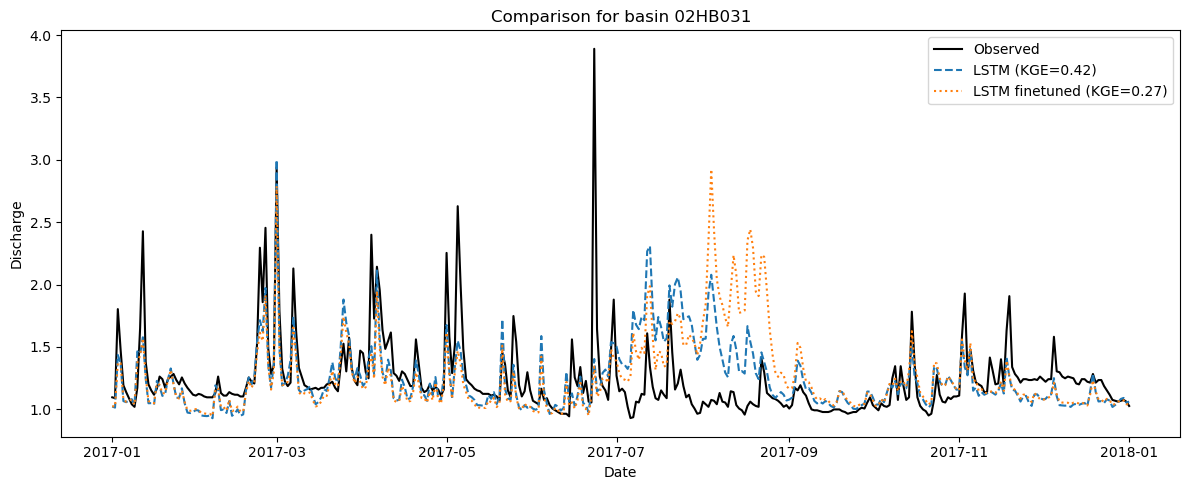

In [3]:
from neuralhydrology.utils.run_analysis import load_results


run_dir1 = Path("runs") / "hysets_2608_014357"
run_dir2 = Path("runs") / "cvc_finetune_04_0209_004823"

results1 = load_results(run_dir1, epoch=-1)
results2 = load_results(run_dir2, epoch=-1)

basin = cvc_basins[1]

def plot_compare_hydrographs(results1, results2, basin, date_range=None):
    dat1 = results1[basin]['1D']["xr"]
    dat2 = results2[basin]['1D']["xr"]
    discharge_obs = dat1['discharge_obs'].squeeze()
    discharge_sim1 = dat1['discharge_sim'].squeeze()
    discharge_sim2 = dat2['discharge_sim'].squeeze()
    dates = dat1['date'].values

    if date_range is not None:
        start, end = [np.datetime64(d) for d in date_range]
        mask = (dates >= start) & (dates <= end)
        discharge_obs = discharge_obs[mask]
        discharge_sim1 = discharge_sim1[mask]
        discharge_sim2 = discharge_sim2[mask]
        dates = dates[mask]

    kge1 = metrics.kge(discharge_sim1, discharge_obs)
    kge2 = metrics.kge(discharge_sim2, discharge_obs)

    plt.figure(figsize=(12, 5))
    plt.plot(dates, discharge_obs, label='Observed', color='black')
    plt.plot(dates, discharge_sim1, label=f'LSTM (KGE={kge1:.2f})', linestyle='--')
    plt.plot(dates, discharge_sim2, label=f'LSTM finetuned (KGE={kge2:.2f})', linestyle=':')
    plt.xlabel('Date')
    plt.ylabel('Discharge')
    plt.title(f'Comparison for basin {basin}')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_compare_hydrographs(results1, results2, basin, date_range=["2017-01-01", "2018-01-01"])


## Plot hydrographs for another run
Load and plot hydrographs for a different run and basin.

In [71]:
run_dir = Path("runs") / "hysets_1408_001610"

test_results = load_results(run_dir, epoch=-1)
plot_hydrographs(test_results, basin, date_range=["2017-01-01", "2018-01-01"])

KeyError: '02HB031'

## Visualize basin boundaries in Southern Ontario
Clip and plot basin boundaries for Southern Ontario using geopandas.

In [ ]:
df = load_hysets_boundaries(data_dir=data_dir)

# Define Southern Ontario bounding box (approximate)

# minx, miny, maxx, maxy
southern_ontario_bbox = (-85, 41.5, -74, 45.5)

# Clip the GeoDataFrame to the bounding box
df_so = df.cx[southern_ontario_bbox[0]:southern_ontario_bbox[2], southern_ontario_bbox[1]:southern_ontario_bbox[3]]

# If you want to use a basemap with geopandas.explore, you need to specify the tiles parameter.
# For example, you can use "OpenStreetMap" as the basemap:
# If the basemap is not displaying, try using a different tile provider or check your internet connection.
# You can also try "OpenStreetMap" as the tiles parameter:
df_so.set_crs(epsg=4326, inplace=True)
df_so.explore(tiles="OpenStreetMap", tooltip="Name")

c:\Users\everett\.conda\envs\neuralhydrology\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


## Placeholder cell
This cell is reserved for future code or notes.

## Placeholder cell
This cell is reserved for future code or notes.